In [1]:
!pip install remotezip tqdm opencv-python==4.5.2.52 opencv-python-headless==4.5.2.52 tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import tqdm
import random
import pathlib
import itertools
import collections
import os
import shutil
from pathlib import Path

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def list_files_per_class(dir):
  '''
  List the files in each class of the dataset given the directory

  Args:
    dir: Directory for files

  Return:
    files: List of files in each of the calsses
  '''
  files = []
  folders = os.listdir(dir)

  for cls in folders:
    for file in os.listdir(path+cls):
      files.append(path+cls+'/'+ file)
  #for cls in folders:
  #  files.append(os.path.join(dir+cls,file) for file in os.listdir(dir+cls))
  
  return files

def get_class(fname):
  '''
  Retrieve name of the class given a filename

  Args:
    fname: Name of the file 
  
  Return:
    Class that the file belongs to
  '''
  return fname.split('/')[-2]

def get_files_per_class(files):
  '''
  Retrieve the files that belong to each class

  Args:
    files: List of files in the dataset
  
  Return:
    Dictionary of class names (key) and files (values)
  '''

  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_folder(path,to_dir, file_names):
  '''
  Download the contents from a folder 

  Args:
    path: path to location containing data
    to_dir: Directory to download data to
    file_names: Names of files to download
  '''

  for fn in tqdm.tqdm(file_names):
    class_name = get_class(fn)
    fn = pathlib.Path(fn).parts[-1]
    origin_file = path + class_name + '/' + fn

    if os.path.exists(to_dir+'/'+class_name):
      output_file = to_dir + '/' + class_name + '/' + fn
      shutil.copy(origin_file, output_file)
    else:
      os.mkdir(to_dir+'/'+class_name)
      output_file = to_dir + '/' + class_name + '/' + fn
      shutil.copy(origin_file, output_file)

def split_class_lists(files_for_class,count):
  '''
  Returns the list of files belonging to a subset of data as well as the remainder of files that need to be downloaded

  Args:
    files_for_class: Files belonging to a particular class of data
    count: Number of files to download
  
  Return:
    split_files: Files belonging to the subset of data
    remainder: Dicitonary of the remainder of files that need to be downloaded
  '''
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_subset(path, num_classes, splits, download_dir):
  '''
  Download a subset of the dataset and split them into various parts, such as 
  training, validation, and test

  Args:
    path: data location
    num_classes: Number of labels
    splits:  Dictionary specifying the training, validation, test, etc. (key) division of data 
      (value is number of files per split)
    download_dir: Directory to download data to

  Return: 
    dir: Posix path of the resulting direcotry containing the splits of data
  '''

  if os.path.exists(download_dir) == False: 
    os.mkdir(download_dir)
  
  files = list_files_per_class(path)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <=2:
      files.remove(f) # Remove that item from the list if it does not have a filename
    
    files_for_class = get_files_per_class(files)

    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
      new_files_for_class = files_for_class[cls]
      random.shuffle(new_files_for_class)
      files_for_class[cls] = new_files_for_class
    
    # Only use the number of classes you want in the dictionary
    files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

    dirs = {}
    for split_name, split_count in splits.items():
      print(split_name, ":")
      split_dir = download_dir + '/' + split_name 
      if os.path.exists(split_dir) == False:
        os.mkdir(split_dir)
        
      split_files, files_for_class = split_class_lists(files_for_class, split_count)
      download_from_folder(path,split_dir, split_files)
      dirs[split_name] = split_dir
    
    return dirs

def format_frames(frame, output_size):
  '''
  Pad and resize an image from a video

  Args:
    frame: Image that needs to resized and padded
    output_size: Pixel size of the output frame size
  
  Return:
    Formatted frame with padding of specified output size
  '''

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  '''
  Creates frames from each video file present for each category

  Args:
    video_path: File path to the video
    n_frames: Number of frames to be created per video file
    output_size: Pixel size of the output frame image

  Return:
    Numpy array of frames in the shape of (n_frames, height, width, channels)
  '''

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames -1)*frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start+1)
  
  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[...,[2,1,0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = Path(path)
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Omdena_MP/task3/PoseVids/'
download_dir = path+'subset'
subset_paths = download_subset(
    path,
    num_classes = 8,
    splits = {'train':30, 'test':20},
    download_dir=download_dir
)

train :


100%|██████████| 213/213 [02:15<00:00,  1.57it/s]


test :


100%|██████████| 36/36 [00:16<00:00,  2.21it/s]


In [6]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [7]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor([2 5 6 3 1 7 1 7], shape=(8,), dtype=int16)
tf.Tensor([6 0 2 0 7 0 0 6], shape=(8,), dtype=int16)
tf.Tensor([7 7 7 0 6 5 1 6], shape=(8,), dtype=int16)
tf.Tensor([7 6 3 1 6 3 2 3], shape=(8,), dtype=int16)
tf.Tensor([3 4 5 0 1 7 6 7], shape=(8,), dtype=int16)
tf.Tensor([6 6 4 2 1 1 5 3], shape=(8,), dtype=int16)
tf.Tensor([3 5 4 5 1 5 7 0], shape=(8,), dtype=int16)
tf.Tensor([5 7 0 6 7 4 0 4], shape=(8,), dtype=int16)
tf.Tensor([7 6 7 4 2 6 1 2], shape=(8,), dtype=int16)
tf.Tensor([7 3 0 0 5 4 2 2], shape=(8,), dtype=int16)


In [8]:
print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

Shape: (8, 8, 224, 224, 3)
Label: (8,)


In [9]:
gru = layers.GRU(units=4, return_sequences=True, return_state=True)

inputs = tf.random.normal(shape=[1,10,8]) # (batch, sequence, channels)

result, state = gru(inputs) # Run it all at once

In [10]:
first_half, state = gru(inputs[:, :5, :]) # run the first half, and capture the state
second_half, _ = gru(inputs[:,5:, :], initial_state=state) # Use the state to continue where you left off

print(np.allclose(result[:,:5:], first_half))
print(np.allclose(result[:, 5:, :], second_half))

True
True


In [11]:
model_id = 'a0'
resolution = 224 

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pretrained weight from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None,None,None,None,3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [12]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  '''Builds a classifier on top of a backbone model.'''
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes
  )
  model.build([batch_size, num_frames, resolution, resolution,3])

  return model

In [13]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)

In [14]:
num_epochs = 2

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

In [16]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
31/31 [==============================] - 271s 9s/step - loss: 1.0299 - accuracy: 0.7642 - val_loss: 5.8057 - val_accuracy: 0.0000e+00
Epoch 2/2
31/31 [==============================] - 232s 8s/step - loss: 0.2288 - accuracy: 0.9472 - val_loss: 7.2847 - val_accuracy: 0.0000e+00


In [17]:
model.evaluate(test_ds, return_dict=True)

10/10 [==============================] - 62s 6s/step - loss: 7.3408 - accuracy: 0.0000e+00


{'loss': 7.340765476226807, 'accuracy': 0.0}

In [18]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [19]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [20]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

10/10 [==============================] - 66s 6s/step


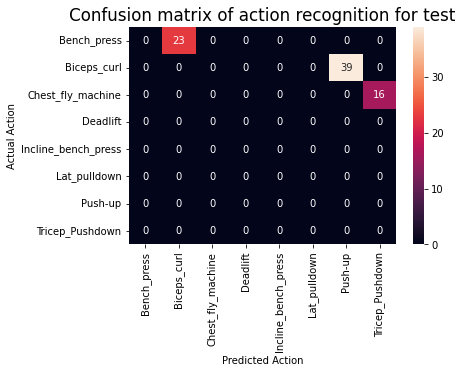

In [21]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')